In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_design_matrix, plot_stat_map, view_img
from nilearn.reporting import get_clusters_table
from nilearn import datasets
import glob
import os
import numpy as np
import pandas as pd

# import sys
# sys.path.append('/Users/zeynepenkavi/Documents/RangelLab/DescribedVsLearned_fmri/analysis/03_level3')
# from make_design_files import make_design_files

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [41]:
def get_filt_tval_img(reg, reg_rt = "1", mnum = "1", mname = 'overall_mean', tstat="1", threshold=0.95):
    
    level3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/'
    model_path = 'model'+mnum+'_reg-rt'+reg_rt
    img_path = os.path.join(level3_path, model_path, mname, reg+'_'+model_path)
    
    
    pos_pval_fn = 'rand_tfce_corrp_%s_%s_model%s_reg-rt%s_tstat%s.nii.gz'%(mname, reg, mnum, reg_rt, tstat)
    neg_pval_fn = 'rand_tfce_corrp_%s_%s_model%s_reg-rt%s_tstat%s.nii.gz'%(mname, 'neg_'+reg, mnum, reg_rt, tstat)
    tval_fn = 'rand_tfce_%s_%s_model%s_reg-rt%s_tstat%s.nii.gz'%(mname, reg, mnum, reg_rt, tstat)
    
    pos_pval_img = os.path.join(img_path, pos_pval_fn)
    neg_pval_img = os.path.join(img_path, neg_pval_fn)
    tval_img = os.path.join(img_path, tval_fn)
    
    pos_pval_img = nib.load(pos_pval_img)
    neg_pval_img = nib.load(neg_pval_img)
    tval_img = nib.load(tval_img)
    
    tval_data = tval_img.get_fdata()
    pos_pval_data = pos_pval_img.get_fdata()
    neg_pval_data = neg_pval_img.get_fdata()
    
    filt_tval_data = np.where(pos_pval_data > threshold, tval_data, np.where(neg_pval_data > threshold, tval_data, 0))
    filt_tval_img = nib.Nifti1Image(filt_tval_data.astype(np.float64), tval_img.affine)
    
    return filt_tval_img

def plot_filt_tval_img(reg, reg_rt = "1", mnum = "1", mname = 'overall_mean', tstat="1", threshold=0.95, interactive=False, cut_coords = None):
    filt_tval_img = get_filt_tval_img(reg=reg, reg_rt = reg_rt, mnum = mnum, mname = mname, tstat=tstat, threshold=threshold)
    if(len(np.unique(filt_tval_img.get_fdata())) == 1):
        print('Nothing survives correction for %s, model = %s, tstat = %s'%(reg, mnum, tstat))
    elif interactive:
        view = view_img(filt_tval_img, 
             draw_cross=False,
             title='%s_model%s_reg-rt%s'%(reg, mnum, reg_rt), cut_coords = cut_coords)
        
        return view
    else:
        print('Plotting tvalues filtered for corrected p values > %s'%str(round(1-threshold, 2)))
        plot_stat_map(filt_tval_img, 
             draw_cross=False,
             title='%s_model%s_reg-rt%s'%(reg, mnum, reg_rt), cut_coords = cut_coords)

def get_mean_cor_df(reg_rt = "1", mnum = "1"):
    
    level3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/'
    model_path = 'model'+mnum+'_reg-rt'+reg_rt
    df_path = os.path.join(level3_path, model_path, model_path+'_mean_desmat_cor.csv')
    
    mean_cor_df = pd.read_csv(df_path)
    
    return(mean_cor_df)

# Regressor types

- ev = event; amplitude = 1  
- par = parametric; amplitude = demeaned    
- st = stick (0 duration); amplitude = 1 

# Model 1: fractalProb_ev + stim_ev + choice_st + reward_ev

Correlation between regressors averaged across subjects and runs

Plotting tvalues filtered for corrected p values > 0.05
Plotting tvalues filtered for corrected p values > 0.05


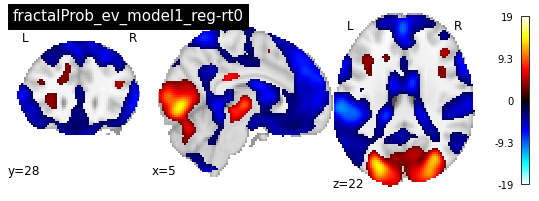

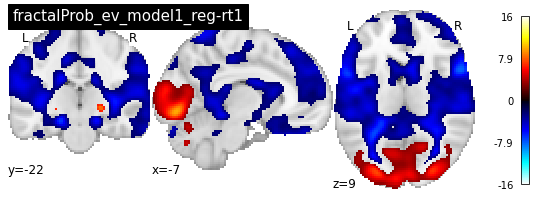

In [31]:
reg = 'fractalProb_ev'
mnum = '1'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

Plotting tvalues filtered for corrected p values > 0.05
Plotting tvalues filtered for corrected p values > 0.05
Plotting tvalues filtered for corrected p values > 0.05


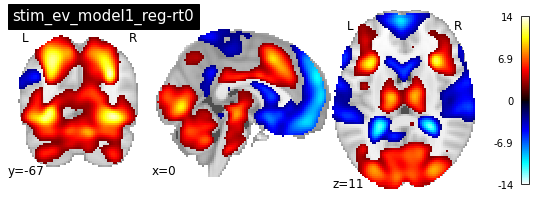

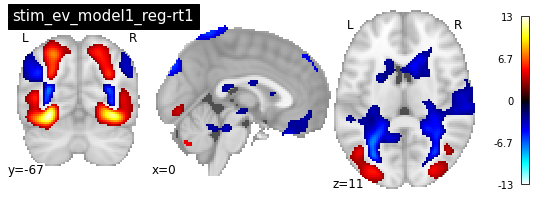

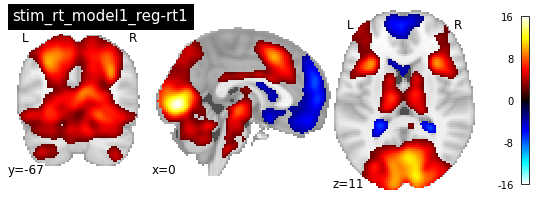

In [32]:
reg = 'stim_ev'
mnum = '1'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = (0, -67, 11))

reg = 'stim_rt'
mnum = '1'
mname = 'overall_mean'
tstat = '1'

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = (0, -67, 11))

Plotting tvalues filtered for corrected p values > 0.05
Plotting tvalues filtered for corrected p values > 0.05


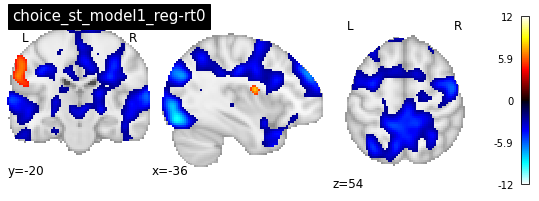

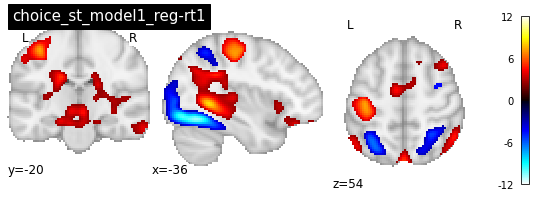

In [39]:
reg = 'choice_st'
mnum = '1'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = (-36, -20, 54))

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = (-36, -20, 54))

Plotting tvalues filtered for corrected p values > 0.05
Plotting tvalues filtered for corrected p values > 0.05


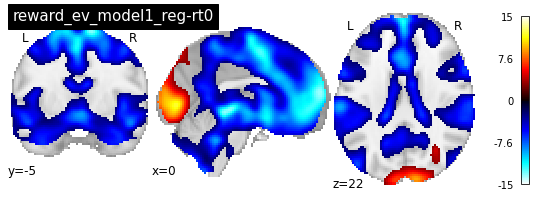

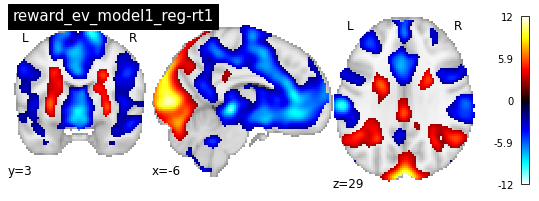

In [12]:
reg = 'reward_ev'
mnum = '1'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

# Model 2: Model 1 + fractalProb_par

# Model 3: Model 2 + valDiff_par

# Model 4: Model 2 + valChosen + valUnchosen

# Model 5: Model 2 + valDiffLottery + valDiffFractal

# Model 6: Model 2 + valChosenLottery + valUnchosenLottery + valChosenFractal + valUnchosenFractal

# Model ...: Model(3/4/5/6) + reward_par

# Model ...: Model(3/4/5/6) + rpe_par

# Model ...: Model(3/4/5/6) + reward_par + rpe_par